In [1]:
'FAIL'

'FAIL'

In [22]:
import pandas as pd
import numpy as np
import pickle as pkl
import tensorflow as tf

from tensorflow import keras
from keras import Model, metrics, layers
from keras.models import Sequential
from keras.metrics import AUC, BinaryAccuracy
from keras.layers import Dense, Dropout, Flatten, Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import SGD

import sys
sys.path.append('../')
from utils import *

In [15]:
sessions = pd.read_pickle('../../data/new_age/sessions')
history_data = pd.read_pickle('../../data/new_age/history')
videos = pd.read_pickle('../../data/new_age/video_data')

In [16]:
from random import shuffle

def trim(vec, element, length=15):
    #  a vector to length and keep the element
    if len(vec) > length:
        vec = vec[:length]
    if element not in vec:
        vec = vec[:-1] + [element]

    return vec

In [17]:
def get_history(u):
    h = history_data[u]
    title = h['title']
    tags = h['tags']
    topics = h['topics']

    tags = np.pad(tags, (0, len(title) - len(tags)), 'constant', constant_values=0)
    topics = np.pad(topics, (0, len(title) - len(topics)), 'constant', constant_values=0)

    return np.vstack([title, tags, topics])

def get_video(v):
    title = videos[v]['title']
    tags = videos[v]['tags']
    topics = videos[v]['topics']

    # pad tags to make it the same length as title
    tags = np.pad(tags, (0, len(title) - len(tags)), 'constant', constant_values=0)
    topics = np.pad(topics, (0, len(title) - len(topics)), 'constant', constant_values=0)

    return np.vstack([title, tags, topics])

In [18]:
from sklearn.model_selection import train_test_split
training, testing = train_test_split(sessions, test_size=0.2)

In [34]:
def get_data(data):
    playing = []
    suggestions = []
    history = []
    Y = []

    for i in range(15):
        suggestions.append([])

    for session in data:
        pp = session['playing']
        selected = session['selected']
        suggesteds = session['suggesteds']
        user = session['user']

        suggesteds = trim(suggesteds, selected)
        
        if pp not in videos or selected not in videos or any([s not in videos for s in suggesteds]):
            continue

        H = get_history(user)
        P = get_video(pp)
        S = []
        y = []

        # MAJOR
        shuffle(suggesteds)

        for i, s in enumerate(suggesteds):
            if s == selected:
                y.append(1)
            else:
                y.append(0)
            s = get_video(s)
            S.append(s)
        
        if len(S) < 15:
            continue

        playing.append(P)
        Y.append(y)
        history.append(H)

        for i in range(15):
            suggestions[i].append(S[i])
        
    return np.array(history), np.array(playing), np.array(suggestions), np.array(Y)

In [55]:
history, playing, suggestions, Y = get_data(training)
history_test, playing_test, suggestions_test, Y_test = get_data(testing)

In [58]:
DIM = (3, 1536)
DP = 0.3

In [57]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Concatenate, BatchNormalization, Softmax
from tensorflow.keras.models import Model
import tensorflow as tf

def self_attention(x):
    query = Dense(256)(x)
    key = Dense(256)(x)
    value = Dense(256)(x)
    
    scores = tf.matmul(query, key, transpose_b=True)
    attention_weights = tf.nn.softmax(scores, axis=-1)
    weighted_sum = tf.matmul(attention_weights, value)
    
    return weighted_sum

In [60]:
suggested_inputs = [Input(shape=DIM) for i in range(15)]
playing_input = Input(shape=DIM)
history_input = Input(shape=DIM)

sg_denses = []

for sg_input in suggested_inputs:
    sg = Dense(512, activation='relu')(sg_input)
    sg = Dropout(DP)(sg)
    sg = Dense(256, activation='relu')(sg)
    sg = Dropout(DP)(sg)
    sg = Flatten()(sg)
    sg = Dense(256, activation='relu')(sg)
    sg = self_attention(sg)
    sg_denses.append(sg)


pl_dense = Dense(512, activation='relu')(playing_input)
pl_dense = Dropout(DP)(pl_dense)
pl_dense = Dense(256, activation='relu')(pl_dense)
pl_dense = Dropout(DP)(pl_dense)
pl = Flatten()(pl_dense)
pl = Dense(256, activation='relu')(pl)

h_dense = Dense(512, activation='relu')(history_input)
h_dense = Dropout(DP)(h_dense)
h_dense = Dense(256, activation='relu')(h_dense)
h_dense = Dropout(DP)(h_dense)
h = Flatten()(h_dense)
h = Dense(256, activation='relu')(h)

merged = Concatenate()([pl, h] + sg_denses)

d = Dense(1024, activation='relu')(merged)
d = Dense(256, activation='relu')(d)
d = Dropout(DP)(d)
flatten = Flatten()(d)
dense1 = Dense(512, activation="relu")(flatten)
dense1 = Dropout(DP)(dense1)
dense1 = BatchNormalization()(dense1)
dense1 = Dense(256, activation="relu")(dense1)
dense1 = Dense(64, activation="relu")(dense1)
output = Dense(15, activation="softmax")(dense1)

model = Model(inputs=[playing_input, history_input] + suggested_inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_239 (InputLayer)      [(None, 3, 1536)]            0         []                            
                                                                                                  
 input_240 (InputLayer)      [(None, 3, 1536)]            0         []                            
                                                                                                  
 input_241 (InputLayer)      [(None, 3, 1536)]            0         []                            
                                                                                                  
 input_242 (InputLayer)      [(None, 3, 1536)]            0         []                            
                                                                                           

In [61]:
model.fit([playing, history] + list(suggestions), Y, epochs=40, batch_size=32, validation_split=0.2)

Epoch 1/40
372/372 [==============================] - 41s 47ms/step - loss: 2.7875 - accuracy: 0.0623 - val_loss: 2.7451 - val_accuracy: 0.0696
Epoch 2/40
372/372 [==============================] - 13s 36ms/step - loss: 2.7573 - accuracy: 0.0646 - val_loss: 2.7470 - val_accuracy: 0.0743
Epoch 3/40
372/372 [==============================] - 14s 38ms/step - loss: 2.7552 - accuracy: 0.0639 - val_loss: 2.7453 - val_accuracy: 0.0696
Epoch 4/40
372/372 [==============================] - 14s 38ms/step - loss: 2.7540 - accuracy: 0.0687 - val_loss: 2.7454 - val_accuracy: 0.0696
Epoch 5/40
372/372 [==============================] - 14s 37ms/step - loss: 2.7542 - accuracy: 0.0688 - val_loss: 2.7453 - val_accuracy: 0.0696
Epoch 6/40
372/372 [==============================] - 14s 37ms/step - loss: 2.7541 - accuracy: 0.0629 - val_loss: 2.7453 - val_accuracy: 0.0696
Epoch 7/40
372/372 [==============================] - 14s 37ms/step - loss: 2.7544 - accuracy: 0.0693 - val_loss: 2.7452 - val_accuracy:

KeyboardInterrupt: 

In [43]:
model.evaluate([playing_test, history_test] + list(suggestions_test), Y_test)

117/117 [==============================] - 1s 8ms/step - loss: 2.7499 - accuracy: 0.0741


[2.7499098777770996, 0.07409396022558212]

In [34]:
a = embedding([anchornp_test, anchornp_test])
p = embedding([anchornp_test, positivenp_test])
ns = []

for i in range(14):
    ns.append(embedding([anchornp_test, negativesnp_test[i]]))


In [35]:
i

13

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

tp = 0
tn = 0
total = 0
ranks = []

for i in range(3631):
    at = np.array(a[i])
    pt = np.array(p[i])
    nst = [np.array(ns[j][i]) for j in range(14)]

    pv = cosine_similarity(at.reshape(1, -1), pt.reshape(1, -1)).flatten()[0]
    nvs = [cosine_similarity(at.reshape(1, -1), nst[j].reshape(1, -1)).flatten()[0] for j in range(14)]

    sims = [pv] + nvs
    simnv = nvs

    sims.sort(reverse=True)
    rank = sims.index(pv) + 1
    ranks.append(rank)

    if pv > np.max(simnv):
        tp += 1
    elif pv < np.min(simnv):
        tp += 1
    else:
        tn += 1


    total += 1

2023-08-24 23:42:55.832600: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 3643 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 3643 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [37]:
tp / total


0.0

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0., 3643.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.]),
 array([0.5       , 0.56666667, 0.63333333, 0.7       , 0.76666667,
        0.83333333, 0.9       , 0.96666667, 1.03333333, 1.1       ,
        1.16666667, 1.23333333, 1.3       , 1.36666667, 1.43333333,
        1.5       ]),
 <BarContainer object of 15 artists>)

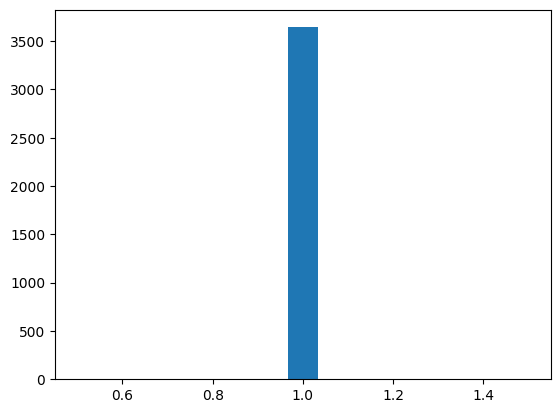

In [38]:
from matplotlib import pyplot as plt

plt.hist(ranks, bins=15)

In [21]:
1/15

0.06666666666666667